In [234]:
import numpy as np
import pandas as pd
import yfinance as yf
import matplotlib.pyplot as plt
import datetime as dt

In [236]:
# Option Data Retrieval
def options_data(ticker: str):
    asset = yf.Ticker(ticker) # sets the asset variable to the ticker object, specified in the string
    expiries = asset.options # returns the associated expiration dates with the options on the asset
    opt_chain = pd.DataFrame() 

    for expiry in expiries:
        # Summoning the option chains for every expiration date
        option = asset.option_chain(expiry)

        # For all call options, add a column with the name option_type and have it's value be the string 'Call'
        calls = option.calls
        calls['option_type'] = 'CALL'

        # Same for puts <3
        puts = option.puts
        puts['option_type'] = 'PUT'

        # Now we can merge the option_type column for calls and puts
        merged_chain = pd.concat([calls, puts])
        # Add column for expiration date and ensure that expiration is at the end of the day
        merged_chain['Expiry'] = pd.to_datetime(expiry) + pd.DateOffset(hours = 23, minutes = 59, seconds = 59)

        # Add information from this iteration to the main dataframe
        opt_chain = pd.concat([opt_chain, merged_chain])

    # Add column to finalized dataframe that computes days to expiry from the current date and date of expriation
    opt_chain['days_to_expiry'] = (opt_chain.Expiry - dt.datetime.today()).dt.days + 1

    return(opt_chain)

        

In [238]:
options_data('AAPL').head()

,contractSymbol,lastTradeDate,strike,lastPrice,bid,ask,change,percentChange,volume,openInterest,impliedVolatility,inTheMoney,contractSize,currency,option_type,Expiry,days_to_expiry
0,AAPL250613C00110000,2025-06-03 17:33:52+00:00,110.0,93.65,93.50,95.15,-0.099998,-0.106665,2.0,24,2.421879,True,REGULAR,USD,CALL,2025-06-13 23:59:59,7
1,AAPL250613C00120000,2025-05-30 19:37:29+00:00,120.0,80.50,83.50,85.15,0.000000,0.000000,4.0,4,2.117192,True,REGULAR,USD,CALL,2025-06-13 23:59:59,7
2,AAPL250613C00125000,2025-06-05 19:24:15+00:00,125.0,75.50,78.50,80.25,0.000000,0.000000,1.0,5,2.011724,True,REGULAR,USD,CALL,2025-06-13 23:59:59,7
3,AAPL250613C00130000,2025-06-04 18:07:08+00:00,130.0,73.50,73.35,74.85,0.000000,0.000000,1.0,4,1.619143,True,REGULAR,USD,CALL,2025-06-13 23:59:59,7
4,AAPL250613C00135000,2025-06-04 19:58:29+00:00,135.0,68.14,68.45,70.20,0.000000,0.000000,8.0,5,1.699220,True,REGULAR,USD,CALL,2025-06-13 23:59:59,7


In [239]:
# Volatility Smile Function
def vol_smile(Type: str, ticker: str, exp_date: str):
    options = options_data(ticker)
    
    # Making a new dataframe that only contains options of a specific type
    target_type = options[options["option_type"] == Type.upper()]

    # At certain expiry
    target_type_at_exp = target_type[target_type['Expiry'] == exp_date]

    plot = target_type_at_exp[['strike', 'impliedVolatility']].set_index('strike').plot(
        title='Volatility Smile'
    )
    
    return(plot)

<Axes: title={'center': 'Volatility Smile'}, xlabel='strike'>

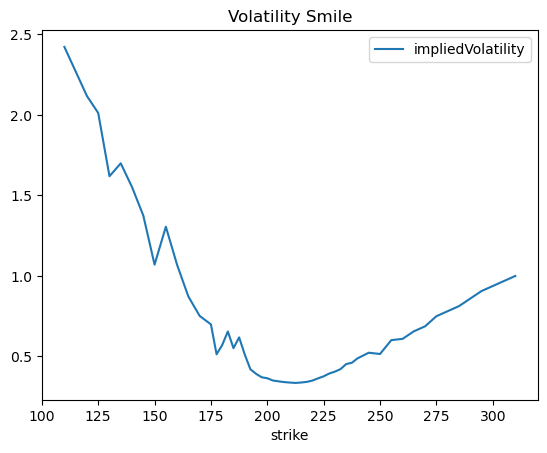

In [240]:
vol_smile('cAll', 'AAPL', '2025-06-13 23:59:59')

In [243]:
# Volatility by Term
def vol_term(Type: str, ticker: str, strike_val: int):
    
    options = options_data(ticker)
    
    # Making a new dataframe that only contains options of a specific type
    target_type = options[options["option_type"] == Type.upper()]

    # At certain strike
    target_type_at_strike = target_type[target_type['strike'] == strike_val]

    plot = target_type_at_strike[['Expiry', 'impliedVolatility']].set_index('Expiry').plot(
        title='Volatility Term'
    )
    
    return(plot)

<Axes: title={'center': 'Volatility Term'}, xlabel='Expiry'>

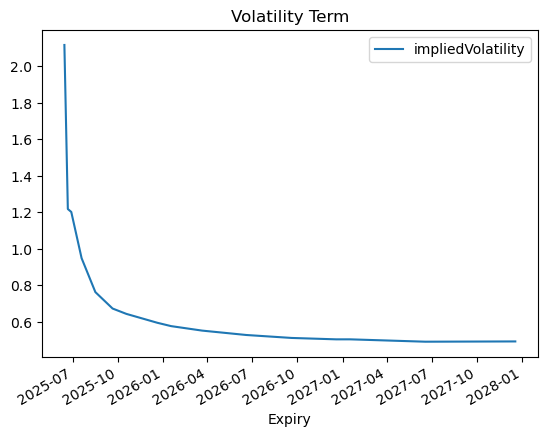

In [244]:
vol_term('call', 'AAPL', 120.0)

In [247]:
def vol_surface(Type: str, ticker: str):
    
    options = options_data(ticker)
    
    # Making a new dataframe that only contains options of a specific type
    target_type = options[options["option_type"] == Type.upper()]

    # Create surface dataframe
    surface = (
        target_type[['days_to_expiry','strike','impliedVolatility']].pivot_table(values = 'impliedVolatility', index = 'strike', columns = 'days_to_expiry').dropna()
    )

    # Initialize a figure and create a projection element
    fig = plt.figure(figsize=(10, 8))
    ax = fig.add_subplot(111, projection='3d')

    # Retrieve values from surface dataframe + convert expiry and strike to grid over which IV will be projected
    x, y, z = surface.columns.values, surface.index.values, surface.values
    X, Y = np.meshgrid(x,y)

    # Label the plot
    ax.set_xlabel('Days to expiration')
    ax.set_ylabel('Strike price')
    ax.set_zlabel('Implied volatility')
    ax.set_title('Implied Volatility Surface')

    plot = ax.plot_surface(X, Y, z)
    
    return(plot)

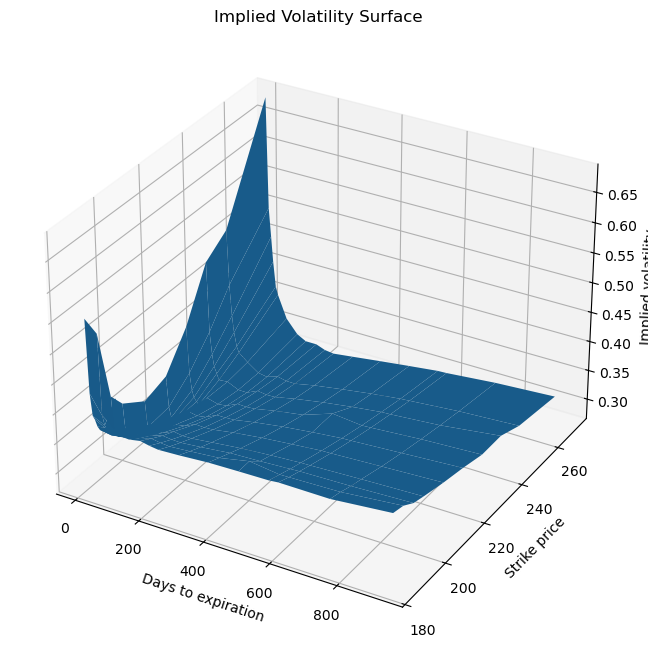

In [250]:
vol_surface('call', 'AAPL')